In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from dotenv import load_dotenv

load_dotenv()

In [ ]:
class CustomAgentState(TypedDict):
    name: str
    age: int
    person: str


In [ ]:
prompt_to_know_gender = ChatPromptTemplate.from_template(
    """
    You are a helpful assistant that determines the most common gender associated with a given first name.

    Task:
    - Read the name carefully.
    - Reply with only one uppercase letter:
      - "M" if the name is usually male.
      - "F" if the name is usually female.
      
    Name: {NAME}
    """
)

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.2)

parser = StrOutputParser()

chain = prompt_to_know_gender | llm | parser

def get_gender(name):
    return chain.invoke({"NAME": name})

In [ ]:
def gender_routing(state: CustomAgentState) -> str:
    gender_decided = get_gender(state["name"])
    print(f"Gender is decided for name `{state['name']}` -> `{gender_decided}`")
    
    if (gender_decided=="M"):
        return "male_edge"
    else:
        return "female_edge"
    

def handle_male(state: CustomAgentState) -> CustomAgentState:
    the_person_is = "Man" if state["age"] > 20 else "Boy"
    print(f"The person with name: {state['name']} is a {the_person_is}")
    state["person"] = the_person_is
    return state


def handle_female(state: CustomAgentState) -> CustomAgentState:
    the_person_is = "Woman" if state["age"] > 20 else "Girl"
    print(f"The person with name: {state['name']} is a {the_person_is}")
    state["person"] = the_person_is
    return state


In [ ]:
graph = StateGraph(CustomAgentState)

graph.add_node("gender_decider", lambda state:state)
graph.add_node("handle_male", handle_male)
graph.add_node("handle_female", handle_female)

graph.add_edge(START, "gender_decider")
graph.add_conditional_edges(
    "gender_decider",
    gender_routing,
    {
        "male_edge": "handle_male",
        "female_edge": "handle_female"
    }
)
graph.add_edge("handle_male", END)
graph.add_edge("handle_female", END)

app = graph.compile()

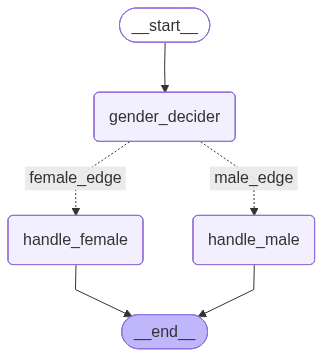

In [10]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
res = app.invoke(CustomAgentState(name="Alice", age=16, person=""))
res